<a href="https://colab.research.google.com/github/JanMeow/productDataOptimization/blob/main/Chapter0_product_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np

In [34]:
!git clone https://github.com/JanMeow/productDataOptimization.git

fatal: destination path 'productDataOptimization' already exists and is not an empty directory.


In [35]:
import pandas as pd
import numpy as np

# Load Excel and sheet names
excel_file = "productDataOptimization/data.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_keys = xls.sheet_names

sheet_data = {}

for sheet_name in sheet_keys:
    df_raw = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)

    # Extract material names from row 3
    raw_material_names = df_raw.iloc[3, 1:].dropna().tolist()
    raw_material_names = [str(name).strip() for name in raw_material_names]
    start_col = 1

    # Track seen keys and build unique names
    name_counts = {}
    final_material_names = []

    for name in raw_material_names:
        if name not in name_counts:
            name_counts[name] = 1
            final_material_names.append(name)
        else:
            name_counts[name] += 1
            final_material_names.append(f"{name}{name_counts[name]}")

    # --- Extract df_0 (properties like Lambda-Wert) ---
    properties_rows = [4, 5]
    properties = []

    for row in properties_rows:
        row_label = df_raw.iloc[row, 0]
        values = df_raw.iloc[row, start_col::2].values[:len(final_material_names)]
        properties.append([row_label] + list(values))

    df_0 = pd.DataFrame(properties, columns=["Property"] + final_material_names)

    # Convert each column (excluding 'Property') into a numpy array
    data_0 = {}
    for material in df_0.columns[1:]:
      values = df_0[material].to_numpy()
      data_0[material] = values

    # --- Extract df_1 as dict of np arrays ---
    data_1 = {}
    name_counts = {}  # Reset to reassign same renaming logic for df_1

    for i, base_name in enumerate(raw_material_names):
        col_thickness = start_col + i * 2
        col_price = col_thickness + 1

        # Get group of entries
        group = []
        for row in range(8, df_raw.shape[0]):
            dicke = df_raw.iloc[row, col_thickness]
            preis = df_raw.iloc[row, col_price]
            if isinstance(dicke, str) or isinstance(preis, str):
                continue
            if pd.notna(dicke) and pd.notna(preis):
                group.append([dicke, preis])

        # Rename key consistently
        if base_name not in name_counts:
            name_counts[base_name] = 1
            final_key = base_name
        else:
            name_counts[base_name] += 1
            final_key = f"{base_name}{name_counts[base_name]}"

        if group:
            data_1[final_key] = np.array(group)

    # Store result
    sheet_data[sheet_name] = {
        "properties": data_0,
        "variants": data_1
    }


In [36]:
look_key = "Aussenwand 1.1"

In [37]:
sheet_data[look_key]["properties"].keys()

dict_keys(['Fassade', 'Spundschalung', 'Konstruktion', 'Zellulosefaserdämmung', 'Gipsfaserplatte'])

In [38]:
sheet_data[look_key]["properties"]

{'Fassade': array([nan, 'RF 3'], dtype=object),
 'Spundschalung': array([0.13, 'RF 3'], dtype=object),
 'Konstruktion': array([0.13, 'RF 3'], dtype=object),
 'Zellulosefaserdämmung': array([0.038, 'RF 2'], dtype=object),
 'Gipsfaserplatte': array([0.32, 'RF 1'], dtype=object)}

In [39]:
if sheet_data[look_key]["properties"].keys() != sheet_data[look_key]["variants"].keys():
  raise Exception("Keys do not match, data missing")

In [40]:
from itertools import product
def get_combinations(data, return_type = "index"):
  if return_type == "index":
    thickness_lists = [list(range(len(layer))) for layer in data.values()]
  else:
    thickness_lists = [layer[:, 0] for layer in data.values()]
  return np.array(list(product(*thickness_lists)))

In [41]:
factors = ["thickness", "price", "U_value", "fire_rating", "acoustics"]

def get_U_values(layers, thicknesses, lambdas, rsi = 0.13, rse = 0.04):
  omitted = ["Fassade", "Konstruktion"]
  mask = [not any(keyword in l for keyword in omitted) for l in layers]
  #thickness/1000 because of lambda unit takes on meter
  partial_u = thicknesses.copy()[mask]/lambdas[mask]/ 1000
  return round(1/(rse + np.sum(partial_u) +rsi),2)

def get_overall_VKF(data):
  rfs = [int(props[1][-1]) for props in data["properties"].values()]
  #0. certain rules apply
  #1. if all layers take the same rf then the overall assembly has the same rf
  #2. if not, take the lowest rfs, programmtically we just always takes the lowest rfs
  #3. the rfs of the construction layer is detemriend by the layers before and after it, take the lowest rfs for the 2
  #4. Second thought the second logic is useless, cause at the end its the lowest one of the layers that matter. ??? Should ask

  for i, layer in enumerate(data["properties"].keys()):
    if "Konstruktion" in layer:
      rf_prev = rfs[i-1]
      rf_next = rfs[i+1]
      # the bigger the value, the worse it is, idea is to take the worse
      if rf_prev > rf_next:
        rfs[i] = rf_prev
      else:
        rfs[i] = rf_next
  return max(rfs)


def get_performance_factors(combinations, data, factors):
  performances = np.zeros((len(combinations), len(factors)))
  properties = data["properties"]
  variants = data["variants"]
  layers = list(variants.keys())
  for i, combination in enumerate(combinations):
    thicknesses = np.array([variants[layers[i]][c][0] for i, c in enumerate(combination)])
    # overall thickness calculations excludes konstruction layer
    thickness_mask = [False if "Konstruktion" in props else True for props in properties.keys()]
    lambdas = np.array([ p[0] for p in properties.values()])
    U_value = get_U_values(layers, thicknesses, lambdas)
    row = performances[i]
    thickness = np.sum(thicknesses[thickness_mask])
    price = np.sum([variants[layers[i]][c][1] for i, c in enumerate(combination)])
    row[0], row[1], row[2] = thickness, price, U_value
  return performances

In [42]:
import time
from functools import wraps
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"⏱️ Function `{func.__name__}` took {end - start:.4f} seconds")
        return result
    return wrapper

In [43]:
@timeit
def get_all_perfromances(sheet_data, factors):
  total_combinations = 0
  for wall, data in sheet_data.items():
    print(wall)
    overall_VKF = get_overall_VKF(data)
    print(overall_VKF)
    combinations = get_combinations(data["variants"], return_type= "index")
    performancees = get_performance_factors(combinations, data, factors)
    data["performances"] = performancees
    total_combinations += len(combinations)
  print(total_combinations)
  return

In [44]:
get_all_perfromances(sheet_data, factors)

Aussenwand 1.1
3
Aussenwand 1.2
3
Aussenwand 1.3
3
Aussenwand 1.7
3
Aussenwand 1.8
3
265837
⏱️ Function `get_all_perfromances` took 18.2735 seconds


In [45]:
sheet_data["Aussenwand 1.1"]["performances"]

array([[2.630e+02, 2.600e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       [2.655e+02, 2.610e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       [2.680e+02, 2.640e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       ...,
       [4.705e+02, 3.270e+02, 1.000e-01, 0.000e+00, 0.000e+00],
       [4.730e+02, 3.300e+02, 1.000e-01, 0.000e+00, 0.000e+00],
       [4.760e+02, 3.330e+02, 1.000e-01, 0.000e+00, 0.000e+00]])

In [46]:
import json

def serialize_sheet_data(sheet_data):
    json_ready = {}

    for sheet_name, content in sheet_data.items():
        sheet_entry = {}

        # Handle 'properties'
        properties_serialized = {}
        for key, value in content["properties"].items():
            props = []
            for v in value:
                if pd.isna(v):
                    props.append(0)  # or use None if you prefer
                else:
                    props.append(v)
            properties_serialized[key] = props

        # Handle 'variants'
        variants_serialized = {
            key: val.tolist() for key, val in content["variants"].items()
        }

        # Handle 'performances'
        performances_serialized = (
            content["performances"].tolist()
            if isinstance(content["performances"], np.ndarray)
            else content["performances"]
        )

        # Combine
        sheet_entry["properties"] = properties_serialized
        sheet_entry["variants"] = variants_serialized
        sheet_entry["performances"] = performances_serialized

        json_ready[sheet_name] = sheet_entry

    return json_ready


In [47]:
json_data = serialize_sheet_data(sheet_data)

with open("sheet_data.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, indent=2, ensure_ascii=False)


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_performance_3d(data_array, threshold):
    """
    Plots a 3D scatter plot of thickness, price, and U-value with threshold lines.

    Parameters:
    - data_array: np.ndarray, shape (n_samples, >=3)
      The first 3 columns should be thickness [mm], price [CHF/m2], and U-value [W/m2K].
    - threshold: list or tuple of 3 elements [min_thickness, min_price, min_u_value]
    """

    assert data_array.shape[1] >= 3, "Input array must have at least 3 columns"

    thickness = data_array[:, 0]
    price = data_array[:, 1]
    u_value = data_array[:, 2]

    # Apply threshold mask
    mask = (thickness >= threshold[0]) & (price >= threshold[1]) & (u_value >= threshold[2])

    # Split into good (green) and bad (red) points
    good = data_array[mask]
    bad = data_array[~mask]

    # Start plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot green (meeting threshold) and red (not meeting)
    ax.scatter(good[:, 0], good[:, 1], good[:, 2], c='green', label='Meets requirement')
    ax.scatter(bad[:, 0], bad[:, 1], bad[:, 2], c='red', label='Does not meet')

    # Plot threshold lines (dashed red)
    xline = [threshold[0], threshold[0]]
    yline = [price.min(), price.max()]
    zline = [u_value.min(), u_value.max()]
    ax.plot(xline, [threshold[1]] * 2, zline, 'r--')
    ax.plot([thickness.min(), thickness.max()], [threshold[1]] * 2, [threshold[2]] * 2, 'r--')
    ax.plot([threshold[0]] * 2, yline, [threshold[2]] * 2, 'r--')

    ax.set_xlabel("Thickness [mm]")
    ax.set_ylabel("Price [CHF/m²]")
    ax.set_zlabel("U-Value [W/m²K]")
    ax.set_title("Material Performance (3D)")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [49]:
look_key = "Aussenwand 1.1"

In [50]:
plot_data = sheet_data[look_key]["performances"]
plot_data

array([[2.630e+02, 2.600e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       [2.655e+02, 2.610e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       [2.680e+02, 2.640e+02, 2.200e-01, 0.000e+00, 0.000e+00],
       ...,
       [4.705e+02, 3.270e+02, 1.000e-01, 0.000e+00, 0.000e+00],
       [4.730e+02, 3.300e+02, 1.000e-01, 0.000e+00, 0.000e+00],
       [4.760e+02, 3.330e+02, 1.000e-01, 0.000e+00, 0.000e+00]])

In [51]:
plot_min = np.max(plot_data, axis = 0)
plot_max = np.min(plot_data, axis = 0)
plot_min, plot_max

(array([4.76e+02, 3.33e+02, 2.20e-01, 0.00e+00, 0.00e+00]),
 array([2.63e+02, 2.60e+02, 1.00e-01, 0.00e+00, 0.00e+00]))

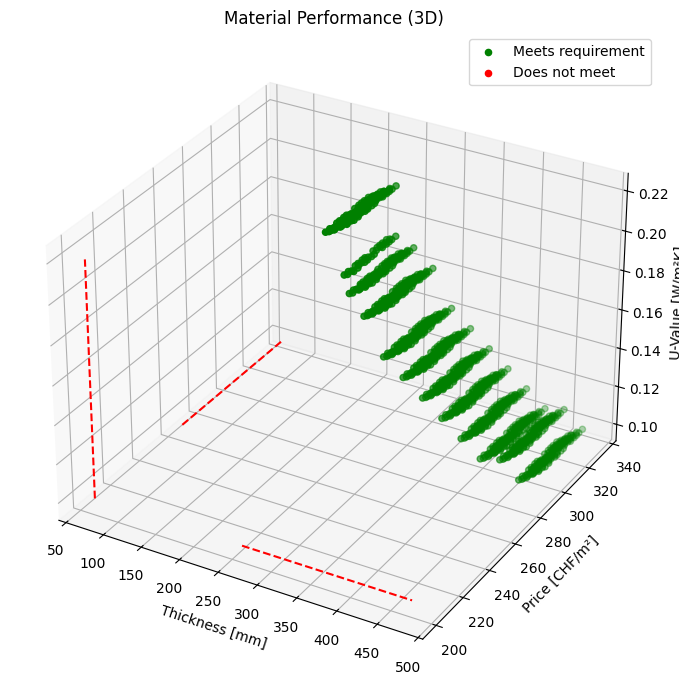

In [52]:
look_key = "Aussenwand 1.1"
plot_performance_3d(sheet_data[look_key]["performances"], threshold=[70, 200, 0.1])

In [53]:
def get_global_bounds(sheet_data):
    all_thickness = []
    all_price = []
    all_u_value = []

    for key in sheet_data:
        data = sheet_data[key]["performances"]
        if data.shape[1] >= 3:  # Ensure at least 3 columns
            all_thickness.append(data[:, 0])
            all_price.append(data[:, 1])
            all_u_value.append(data[:, 2])

    # Concatenate all data
    thickness_all = np.concatenate(all_thickness)
    price_all = np.concatenate(all_price)
    u_value_all = np.concatenate(all_u_value)

    return {
        "thickness": (thickness_all.min(), thickness_all.max()),
        "price": (price_all.min(), price_all.max()),
        "u_value": (u_value_all.min(), u_value_all.max())
    }

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def interactive_3d_plot(sheet_data):

  look_keys = sheet_data.keys()
  initial_data_array = sheet_data["Aussenwand 1.1"]["performances"] #iniital data_array to be used
  min_max_global = get_global_bounds(sheet_data)

  def update(key ="Aussenwand 1.1", t_thresh=0, p_thresh=0, u_thresh=0):
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')

    # Mask
    data_array = sheet_data[key]["performances"]
    thickness = data_array[:, 0]
    price = data_array[:, 1]
    u_value = data_array[:, 2]
    mask = (thickness<= t_thresh) & (price <= p_thresh) & (u_value <= u_thresh)
    good = data_array[mask]
    bad = data_array[~mask]

    # Plot points
    ax.scatter(good[:, 0], good[:, 1], good[:, 2], c='green', label='Meets req')
    ax.scatter(bad[:, 0], bad[:, 1], bad[:, 2], c='red', label='Fails req')

    # Threshold lines
    ax.plot([t_thresh]*2, [price.min(), price.max()], [u_thresh]*2, 'r--')
    ax.plot([thickness.min(), thickness.max()], [p_thresh]*2, [u_thresh]*2, 'r--')
    ax.plot([t_thresh]*2, [p_thresh]*2, [u_value.min(), u_value.max()], 'r--')

    ax.set_xlabel("Thickness [mm]")
    ax.set_ylabel("Price [CHF/m²]")
    ax.set_zlabel("U-Value [W/m²K]")
    ax.legend()
    plt.show()

  # Create sliders
  key_dropdown = widgets.Dropdown(options=look_keys, description='Aussenwand')
  t_slider = widgets.IntSlider(value=400, min=int(min_max_global["thickness"][0]), max = int(min_max_global["thickness"][1]), step=10, description='Max_Thickness')
  p_slider = widgets.IntSlider(value=350, min=int(min_max_global["price"][0]), max=int(min_max_global["price"][1]), step=10, description='Max_Price')
  u_slider = widgets.FloatSlider(value=0.15, min=round(float(min_max_global["u_value"][0]), 3), max=round(float(min_max_global["u_value"][1]), 2), step=0.005, description='Max_U-Value')

  interact_ui = widgets.interactive(update, key =key_dropdown, t_thresh=t_slider, p_thresh=p_slider, u_thresh=u_slider)
  display(interact_ui)


In [55]:
interactive_3d_plot(sheet_data) #400,350,0.16

interactive(children=(Dropdown(description='Aussenwand', options=('Aussenwand 1.1', 'Aussenwand 1.2', 'Aussenw…

In [56]:
"""
1. Remove the price for the requirement
2. Required structural thickness, thickness specified by the architect (add whether its find fittinges or thinest) ## NOT MY PART
L1 or L2 regulariation. plus weight....
3. ***DONE*** Change not max/ min but cloest for the thickness and u value ***DONE***
4. ***DONE*** overthickness exclude completely construction layers  ***DONE***
5. find closest for thickness, max-min range for U value simialr to 3 instead of min/max for U value, i have a target an
"""

'\n1. Remove the price for the requirement\n2. Required structural thickness, thickness specified by the architect (add whether its find fittinges or thinest) ## NOT MY PART\nL1 or L2 regulariation. plus weight....\n3. ***DONE*** Change not max/ min but cloest for the thickness and u value ***DONE***\n4. ***DONE*** overthickness exclude completely construction layers  ***DONE***\n5. find closest for thickness, max-min range for U value simialr to 3 instead of min/max for U value, i have a target an\n'

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def interactive_3d_plot_2(sheet_data, t_tol = 20, u_tol = 0.1):

  look_keys = sheet_data.keys()
  initial_data_array = sheet_data["Aussenwand 1.1"]["performances"] #iniital data_array to be used
  min_max_global = get_global_bounds(sheet_data)

  def update(key ="Aussenwand 1.1", t_thresh=0, p_thresh=0, u_thresh=0, t_tol=t_tol, u_tol = u_tol):
    plt.figure(figsize=(11, 9))
    ax = plt.axes(projection='3d')

    # Mask
    data_array = sheet_data[key]["performances"]
    thickness = data_array[:, 0]
    price = data_array[:, 1]
    u_value = data_array[:, 2]
    mask = (abs(thickness- t_thresh)<= t_tol) & (price <= p_thresh) & (abs(u_value- u_thresh) <= u_tol )
    good = data_array[mask]
    bad = data_array[~mask]

    # Plot points
    ax.scatter(good[:, 0], good[:, 1], good[:, 2], c='green', label='Meets req')
    ax.scatter(bad[:, 0], bad[:, 1], bad[:, 2], c='red', label='Fails req')

    # Threshold lines
    ax.plot([t_thresh]*2, [price.min(), price.max()], [u_thresh]*2, 'r--')
    ax.plot([thickness.min(), thickness.max()], [p_thresh]*2, [u_thresh]*2, 'r--')
    ax.plot([t_thresh]*2, [p_thresh]*2, [u_value.min(), u_value.max()], 'r--')

    ax.set_xlabel("Thickness [mm]")
    ax.set_ylabel("Price [CHF/m²]")
    ax.set_zlabel("U-Value [W/m²K]")
    ax.legend()
    plt.show()

  # Create sliders
  key_dropdown = widgets.Dropdown(options=look_keys, description='Aussenwand')
  t_slider = widgets.IntSlider(value=400, min=int(min_max_global["thickness"][0]), max = int(min_max_global["thickness"][1]), step=10, description='Tar_Thickness')
  p_slider = widgets.IntSlider(value=350, min=int(min_max_global["price"][0]), max=int(min_max_global["price"][1]), step=10, description='Max_Price')
  u_slider = widgets.FloatSlider(value=0.2, min=round(float(min_max_global["u_value"][0]), 3), max=round(float(min_max_global["u_value"][1]), 2), step=0.005, description='Tar_U-Value')
  t_tol_slider = widgets.IntSlider(value=t_tol, min=0, max=50, step=10, description='t_tol')
  u_tol_slider = widgets.FloatSlider(value=u_tol, min=0, max=0.3, step=0.01, description='u_tol')
  interact_ui = widgets.interactive(update, key =key_dropdown, t_thresh=t_slider, p_thresh=p_slider, u_thresh=u_slider,t_tol=t_tol_slider, u_tol = u_tol_slider )
  display(interact_ui)


In [58]:
interactive_3d_plot_2(sheet_data) # 400,340,0.2,20,0.1

interactive(children=(Dropdown(description='Aussenwand', options=('Aussenwand 1.1', 'Aussenwand 1.2', 'Aussenw…

In [59]:
max_min_range = {}
for key, val in sheet_data.items():
  prices = val["performances"][:,1]
  min_price = np.min(prices)
  max_price = np.max(prices)
  max_min_range[key] = np.array([min_price, max_price])
max_min_range

{'Aussenwand 1.1': array([260., 333.]),
 'Aussenwand 1.2': array([284., 367.]),
 'Aussenwand 1.3': array([322., 416.]),
 'Aussenwand 1.7': array([260., 334.]),
 'Aussenwand 1.8': array([326., 419.])}

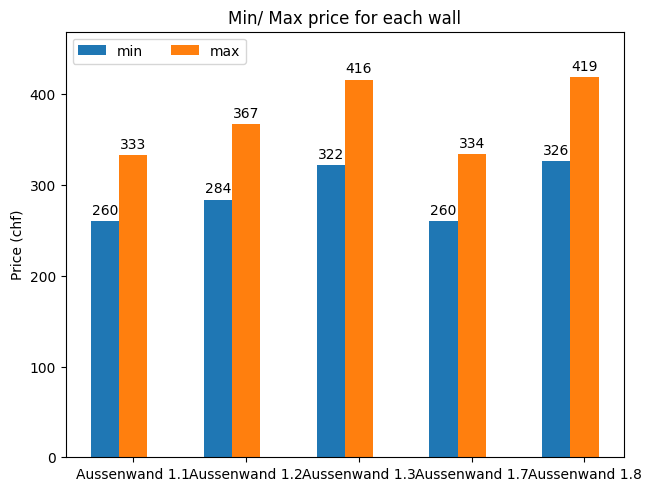

In [60]:
import matplotlib.pyplot as plt
import numpy as np

wall_types = sheet_data.keys()
min_max_arr = np.array([val for val in max_min_range.values()])
plot_min_max = {
    "min": min_max_arr[:,0],
    "max": min_max_arr[:,1]
}
x = np.arange(len(wall_types))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in plot_min_max.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price (chf)')
ax.set_title('Min/ Max price for each wall')
ax.set_xticks(x + width, wall_types)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, np.max(min_max_arr[:,1]+50))

plt.show()

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def interactive_3d_plot_3(sheet_data, t_tol=20, u_tol=0.1):
    look_keys = list(sheet_data.keys())
    min_max_global = get_global_bounds(sheet_data)

    # ---------- inner plotting callback ----------
    def update(key="Aussenwand 1.1",
               t_thresh=0, p_thresh=0, u_thresh=0,
               t_tol=t_tol, u_tol=u_tol):

        data_array = sheet_data[key]["performances"]
        thickness, price, u_value = data_array[:, 0], data_array[:, 1], data_array[:, 2]

        mask = (np.abs(thickness - t_thresh) <= t_tol) & \
               (price <= p_thresh) & \
               (np.abs(u_value - u_thresh) <= u_tol)

        good = data_array[mask]
        bad  = data_array[~mask]

        # ------------ start figure ---------------
        fig = plt.figure(figsize=(11, 9))
        ax  = fig.add_subplot(111, projection='3d')

        # Main scatter
        ax.scatter(good[:, 0], good[:, 1], good[:, 2],
                   c='green', label='Meets req', zorder=2)
        ax.scatter(bad[:, 0],  bad[:, 1],  bad[:, 2],
                   c='red',   label='Fails req', zorder=1)

        # ----- highlight min & max price among valid points -----
        if good.size:
            min_idx, max_idx = np.argmin(good[:, 1]), np.argmax(good[:, 1])
            pt_min, pt_max   = good[min_idx], good[max_idx]

            h_min = ax.scatter(*pt_min[:3], c='yellow', s=90,
                               marker='o', edgecolors='k', zorder=5,
                               label=f"Min CHF {pt_min[1]:.0f}")
            h_max = ax.scatter(*pt_max[:3], c='blue', s=90,
                               marker='o', edgecolors='k', zorder=5,
                               label=f"Max CHF {pt_max[1]:.0f}")

            # Figure text (upper-left in figure coordinates)
            # fig.text(0.02, 0.96,
            #          f"Min price: {pt_min[1]:.1f}  |  "
            #          f"Max price: {pt_max[1]:.1f}  (CHF/m²)",
            #          color='blue', fontsize=10, weight='bold')

        # Threshold guide lines
        ax.plot([t_thresh]*2, [price.min(), price.max()], [u_thresh]*2, 'r--', zorder=0)
        ax.plot([thickness.min(), thickness.max()], [p_thresh]*2, [u_thresh]*2, 'r--', zorder=0)
        ax.plot([t_thresh]*2, [p_thresh]*2, [u_value.min(), u_value.max()], 'r--', zorder=0)

        ax.set_xlabel("Thickness [mm]")
        ax.set_ylabel("Price [CHF/m²]")
        ax.set_zlabel("U-Value [W/m²K]")
        ax.set_title(f"Performance – {key}")
        ax.legend(loc='upper right')
        plt.show()
    # ----------- widgets ----------------
    key_dropdown = widgets.Dropdown(options=look_keys, description='Aussenwand')

    t_slider = widgets.IntSlider(
        value=400, min=int(min_max_global["thickness"][0]),
        max=int(min_max_global["thickness"][1]), step=10,
        description='Tar_Thickness')

    p_slider = widgets.IntSlider(
        value=int(min_max_global["price"][1]), min=int(min_max_global["price"][0]),
        max=int(min_max_global["price"][1]), step=10,
        description='Max_Price')

    u_slider = widgets.FloatSlider(
        value=0.20, min=round(float(min_max_global["u_value"][0]), 3),
        max=round(float(min_max_global["u_value"][1]), 2), step=0.005,
        description='Tar_U-Value')

    t_tol_slider = widgets.IntSlider(value=t_tol, min=0, max=50, step=5,  description='t_tol')
    u_tol_slider = widgets.FloatSlider(value=u_tol, min=0, max=0.3, step=0.01, description='u_tol')

    display(widgets.interactive(
        update,
        key        = key_dropdown,
        t_thresh   = t_slider,
        p_thresh   = p_slider,
        u_thresh   = u_slider,
        t_tol      = t_tol_slider,
        u_tol      = u_tol_slider
    ))


In [62]:
interactive_3d_plot_3(sheet_data, t_tol=20, u_tol=0.1)

interactive(children=(Dropdown(description='Aussenwand', options=('Aussenwand 1.1', 'Aussenwand 1.2', 'Aussenw…